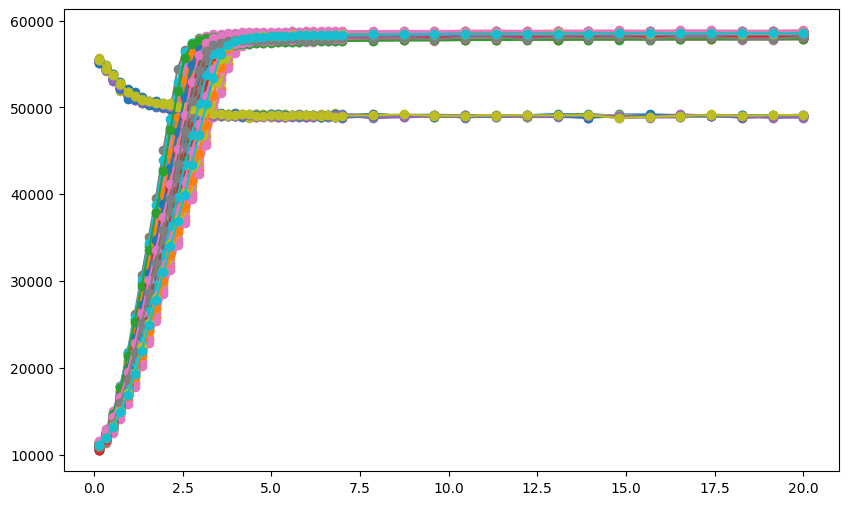

the cube shape is: (50, 10, 10)


In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Jun  2 13:24:45 2025


@author: winter
"""

import os
from collections import defaultdict
# scipy 1d interpolation
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import numpy as np
from utils import extract_pixel_values, find_median_files, get_exposure_time

# make a small subset of the data



roi = (200, 210, 300, 310)

locs = {"sb" : 1}

addr = "sb"
#addr = "sc"

if addr == "sb":
    data_dir = "/Users/frostig/Downloads/flats_20250522" 
else:
    data_dir = "/Users/frostig/Downloads/flats_20250513"
median_files = find_median_files(data_dir)

exposure_times = []
pixel_values_by_ext = defaultdict(list)
board_ids_by_ext = {}

for file in median_files:
    exposure_time = get_exposure_time(os.path.basename(file))
    exposure_times.append(exposure_time)
    pixel_values, board_ids = extract_pixel_values(file)
    for i, value in enumerate(pixel_values):
        pixel_values_by_ext[i].append(value)
        board_ids_by_ext[i] = board_ids[i]

idx_sorted = np.argsort(exposure_times)
sorted_expt = np.array(exposure_times)[idx_sorted]


for ext, values in pixel_values_by_ext.items():
    
    if ext == locs[addr]:
        cube = np.array([values[i] for i in idx_sorted])  # shape: (n, y, x)

        board_id = board_ids_by_ext[ext]

        # downselect the full cube to the roi size
        roi_cube = cube[:, roi[0] : roi[1], roi[2] : roi[3]]

# plot the values in the roi
plt.figure(figsize=(10, 6))
for i in range(roi_cube.shape[1]):
    for j in range(roi_cube.shape[2]):
        plt.plot(sorted_expt, roi_cube[:, i, j], marker="o")
plt.show()

print(f'the cube shape is: {roi_cube.shape}')

shape of max values: (1096, 1984)
lower_pct: 0.25, upper_pct: 99.75


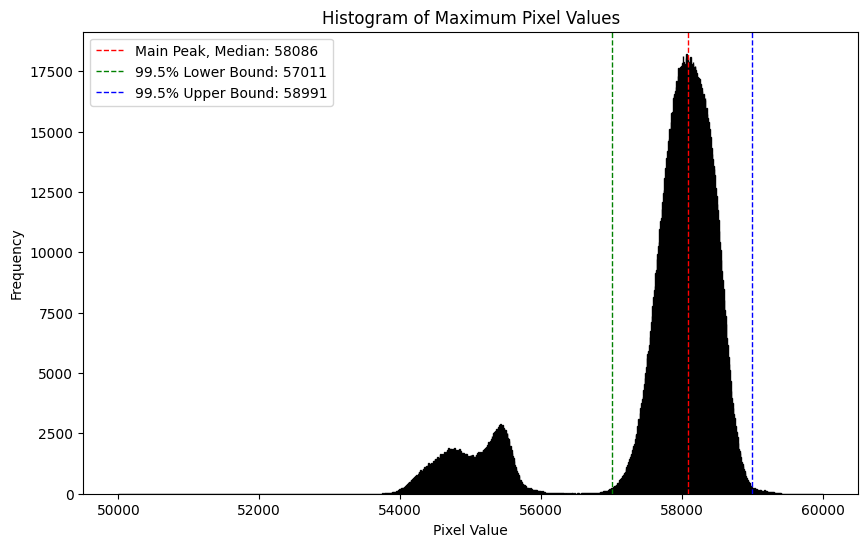

In [4]:
# let's figure out the median saturation value
max_values = np.max(cube, axis=0)
print(f'shape of max values: {max_values.shape}')

flattened_max_values = max_values.flatten()

# make the histogram with numpy
plt.figure(figsize=(10, 6))

hist, bins = np.histogram(flattened_max_values, bins=1000, range=(50000, 60000))
plt.bar(bins[:-1], hist, width=np.diff(bins), edgecolor='black', align='edge')
plt.title('Histogram of Maximum Pixel Values')

# main pea

# calculate the median of the main peak
main_peak = flattened_max_values[flattened_max_values > 56000]
median_saturation_value = np.median(main_peak)
plt.axvline(median_saturation_value, color='red', linestyle='dashed', linewidth=1, label=f'Main Peak, Median: {median_saturation_value:.0f}')

# what values enclose 99.5% of the data?
pct_range = 99.5
lower_pct = (100 - pct_range) / 2
upper_pct = 100 - (100-pct_range) / 2

print(f'lower_pct: {lower_pct}, upper_pct: {upper_pct}')
saturation_lower_bound = np.percentile(main_peak, lower_pct)
saturation_upper_bound = np.percentile(main_peak, upper_pct)



# plot the bounds
plt.axvline(saturation_lower_bound, color='green', linestyle='dashed', linewidth=1, label=f'{pct_range}% Lower Bound: {saturation_lower_bound:.0f}')
plt.axvline(saturation_upper_bound, color='blue', linestyle='dashed', linewidth=1, label=f'{pct_range}% Upper Bound: {saturation_upper_bound:.0f}')


plt.ylabel('Frequency')
plt.xlabel('Pixel Value')
plt.legend()


shape of min values: (1096, 1984)
11463.5
lower_pct: 0.25, upper_pct: 99.75


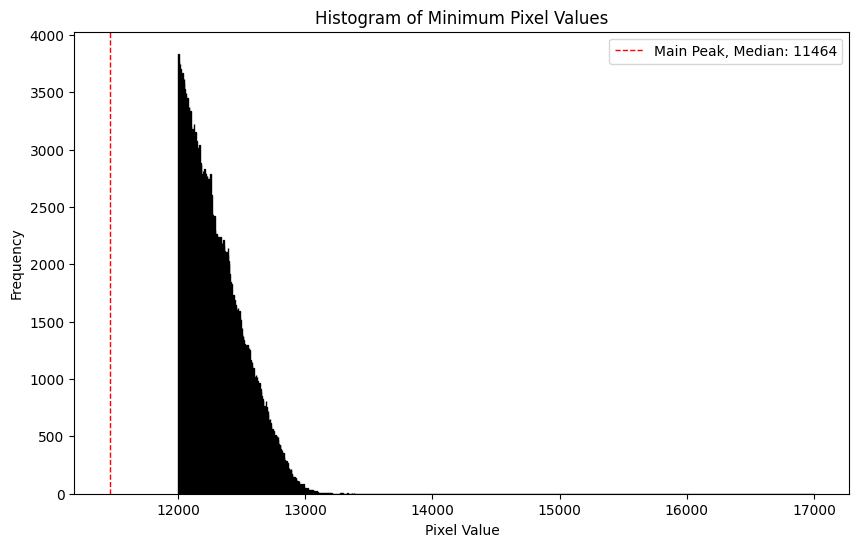

In [5]:
# let's figure out the median bias value
min_values = np.min(cube, axis=0)
print(f'shape of min values: {min_values.shape}')

flattened_min_values = min_values.flatten()

# make the histogram with numpy
plt.figure(figsize=(10, 6))

hist, bins = np.histogram(flattened_min_values, bins=1000, range=(12000, 17000))
plt.bar(bins[:-1], hist, width=np.diff(bins), edgecolor='black', align='edge')
plt.title('Histogram of Minimum Pixel Values')

# main pea

# calculate the median of the main peak
main_peak = flattened_min_values#[flattened_min_values > 56000]
median_saturation_value = np.median(main_peak)
plt.axvline(median_saturation_value, color='red', linestyle='dashed', linewidth=1, label=f'Main Peak, Median: {median_saturation_value:.0f}')
print(median_saturation_value)

# what values enclose 99.5% of the data?
pct_range = 99.5
lower_pct = (100 - pct_range) / 2
upper_pct = 100 - (100-pct_range) / 2

print(f'lower_pct: {lower_pct}, upper_pct: {upper_pct}')
bias_lower_bound = np.percentile(main_peak, lower_pct)
bias_upper_bound = np.percentile(main_peak, upper_pct)



# plot the bounds
#plt.axvline(bias_lower_bound, color='green', linestyle='dashed', linewidth=1, label=f'{pct_range}% Lower Bound: {bias_lower_bound:.0f}')
#plt.axvline(bias_upper_bound, color='blue', linestyle='dashed', linewidth=1, label=f'{pct_range}% Upper Bound: {bias_upper_bound:.0f}')


plt.ylabel('Frequency')
plt.xlabel('Pixel Value')
plt.legend()

In [8]:
# now let's make the corrections
LINEAR_REGION_MINCOUNTS = 20000
LINEAR_REGION_MAXCOUNTS = 50000
#SATURATION = 54000
#EXTRA = 2000
BAD_PIXEL_STD_THRESHOLD = 500

def compute_correction_poly(expt, pixel_series, order, ceiling = None, resample = False, resample_points = 250, resample_interpolation_kind = "linear", plot=False):

    try:
        counts = pixel_series.astype(np.float64)
        mask_linear = (counts > LINEAR_REGION_MINCOUNTS) & (counts < LINEAR_REGION_MAXCOUNTS)
        if mask_linear.sum() < 2:
            return np.full(order + 1, np.nan), True
        if ceiling is None:
            ceiling = np.max(counts)
        max_counts = np.max(counts)

        
            
        linear_fit = np.polyfit(expt[mask_linear], counts[mask_linear], 1)
        if plot:
            fig, ax = plt.subplots(nrows=2, ncols = 3,figsize=(30, 6))
            ax[0,0].plot(expt, counts, "o", label="Raw Counts")
            ax[0,0].plot(expt[mask_linear], counts[mask_linear], "o", label=f"Linear Region: ({len(mask_linear)}) points")
            ax[0,0].plot(expt, np.polyval(linear_fit, expt), label="Linear Fit", color="red")
            # plot a horizontal line at the saturation level
            ax[0,0].axhline(median_saturation_value, linestyle="--", label=f"Median Saturation Level = {median_saturation_value}", color="orange")
            ax[0,0].axhline(max_counts, linestyle="--", label=f"Max Counts = {max_counts:.0f}", color="green")

            ax[0,0].set_ylim(0, np.max(counts) + 10000)
            ax[0,0].set_title("Step 2: Fit a line")

            # on the lower plot, plot the residuals of the linear fit
            residuals = counts[mask_linear] - np.polyval(linear_fit, expt[mask_linear])
            ax[1,0].plot(expt[mask_linear], residuals, "o", label="Residuals in Linear Region")
            ax[1,0].set_xlabel("Exposure Time (s)")
            ax[1,0].set_ylabel("Residuals")
            ax[1,0].set_title("Step 3: Residuals of Linear Fit")




        mu_raw_all = counts.copy()
        mu_cal_all = np.polyval(linear_fit, expt)

        
            
        

        # mask out any points where mu_cal is greater than max(mu_raw_all)
        # the limit is where the linear fit intersects max(mu_raw_all)
        # exposure time at which this occurs
        #expt_intersection = (max_counts - linear_fit[1]) / linear_fit[0]
        #mask_valid = (expt < expt_intersection) #& (counts < (SATURATION + EXTRA))
        
        

        



        #



        if resample:
            mu_raw_linterp = np.linspace(np.min(counts), ceiling, resample_points)
            linterp_1d_func = interp1d(mu_raw_all, mu_cal_all, kind = resample_interpolation_kind)
            mu_cal_linterp = linterp_1d_func(mu_raw_linterp)
            # now append the linterp values to the mu_raw_all and mu_cal_all arrays
            mu_raw = mu_raw_linterp
            mu_cal = mu_cal_linterp
        else:
            mask_valid = mu_cal_all < ceiling
            mu_raw = counts[mask_valid]
            mu_cal = np.polyval(linear_fit, expt[mask_valid])

        fit = np.polyfit(mu_raw, mu_cal, order)

        
        if plot:
            
            
            if resample:
                # just for plottin
                ax[0,1].plot(mu_raw_linterp, mu_cal_linterp, "o", label="Linterp Data", color="purple")
            else:
                ax[0,1].plot(mu_raw, mu_cal, "o", label=f"Selected Data: ({len(mu_raw)}) points")
            # plot the raw data
            ax[0,1].plot(mu_raw_all, mu_cal_all, "o", label="All Data")
            # make a wider range of mu_raw for plotting the polynomial fit
            mu_raw_fit = np.linspace(np.min(mu_raw), 60000, 1000)
            ax[0,1].plot(mu_raw_fit, np.polyval(fit, mu_raw_fit), label=f"Poly Fit -- Order Used: {order})", color="red")
            ax[0,1].axhline(median_saturation_value, linestyle="--", label=f"Median Saturation Level = {median_saturation_value}", color="orange")
            ax[0,1].axvline(median_saturation_value, linestyle="--", color="orange")
            ax[0,1].axvline(LINEAR_REGION_MAXCOUNTS, linestyle="--", label=f"Linear Region Max Counts = {LINEAR_REGION_MAXCOUNTS}", color="green")
            ax[0,1].axhline(LINEAR_REGION_MAXCOUNTS, linestyle="--", color="green")

            ax[0,1].set_xlabel("Raw Counts")
            ax[0,1].set_ylabel("Calibrated Counts")
            ax[0,1].set_title("Step 4: Polynomial Fit to Selected Data")
            ax[0,1].set_ylim(0, 80000)
            

            

        residuals = mu_cal - np.polyval(fit, mu_raw)
        is_bad = np.isnan(fit).any() or residuals.std() > BAD_PIXEL_STD_THRESHOLD

        if plot:
            residual_plot = "percent"
            if residual_plot == "raw":
                # plot the residuals
                ax[1,1].plot(mu_raw, residuals, "o", label="Residuals")
                std_resid = residuals.std()
                mean_resid = residuals.mean()
                ax[1,1].axhline(mean_resid, linestyle="--", label=f"Mean Residual = {mean_resid:.2f}", color="red")
                ax[1,1].axhline(mean_resid + std_resid, linestyle="--", label=f"Mean + Std Dev = {mean_resid + std_resid:.2f}", color="blue")
                ax[1,1].axhline(mean_resid - std_resid, linestyle="--", label=f"Mean - Std Dev = {mean_resid - std_resid:.2f}", color="blue")
                ax[1,1].set_xlabel("Raw Counts")
                ax[1,1].set_ylabel("Residuals")
                ax[1,1].set_title("Step 5: Residuals of Polynomial Fit")
            elif residual_plot == "percent":
                # instead, plot the residuals as a percentage of the bias-corrected counts
                bias_corrected_counts = mu_raw - np.min(mu_raw)
                percent_residuals = (residuals / bias_corrected_counts) * 100
                ax[1,1].plot(bias_corrected_counts, percent_residuals, "o", label="Residuals (%)")
                ax[1,1].set_xlabel("Approx. Bias-Corrected Raw Counts")
                ax[1,1].set_ylabel("Residuals (%)")
                ax[1,1].set_title("Step 5: Residuals of Polynomial Fit (%)")
                ax[1,1].set_ylim(-10,10)
                # calculate point at which abs(residuals) < 5%
                threshold = 2.5
                threshold_mask = np.abs(percent_residuals) > threshold
                cutoff_counts = np.max(bias_corrected_counts[threshold_mask]) if np.any(threshold_mask) else np.nan
                ax[1,1].axvline(cutoff_counts, linestyle="--", label=f"Cutoff Counts for {threshold}% Residuals = {cutoff_counts:.0f}", color="purple")

            
            

        if plot:
            # apply the correction to the raw counts

        
            """
            
            max = np.max(mu_raw)
            max = median_saturation_value
            corrected = np.where(
                            counts > max,
                            np.polyval(fit, max),
                            np.polyval(fit, counts),
                        )
            """
            corrected = np.polyval(fit, counts)

            # apply the ceiling to the corrected counts: apply the ceiling to any raw or corrected counts that exceed the ceiling
            # element‑wise OR: either np.logical_or(...) or the | operator
            mask      = (corrected > ceiling) | (counts > ceiling)
            #            ↑ element‑wise ^

            #corrected = np.where(mask, ceiling, corrected)
            corrected = np.where(mask, counts, corrected) # just use the raw counts where the corrected counts exceed the ceiling
            

            gs = ax[0, 0].get_gridspec()          # the underlying GridSpec
            #remove the two tiny axes we want to replace
            for a in (ax[0, 2], ax[1, 2]):
                a.remove()                        # or fig.delaxes(a)
            # add one big axis that uses the whole third column (all rows)
            big_ax = fig.add_subplot(gs[:, 2])    # rows ‘:’  → both rows, col 2

            big_ax.plot(expt, counts, "o", label="Raw Counts")
            big_ax.plot(expt, corrected, "o", label="Corrected Counts")
            big_ax.axhline(median_saturation_value, linestyle="--", label=f"Median Saturation Level = {median_saturation_value}", color="orange")
            big_ax.axhline(ceiling, linestyle="--", label=f"Ceiling = {ceiling}", color="purple")
            big_ax.axhline(LINEAR_REGION_MAXCOUNTS, linestyle="--", label=f"Linear Region Max Counts = {LINEAR_REGION_MAXCOUNTS}", color="green")
            
            ax[0,1].axhline(ceiling, linestyle="--", label=f"Ceiling = {ceiling}", color="purple")
            ax[0,1].axvline(ceiling, linestyle="--", color="purple")
            big_ax.set_xlabel("Exposure Time (s)")
            big_ax.set_ylabel("Counts")
            big_ax.set_title("Step 6: Apply Polynomial Correction")
            
            ax[0,0].legend()
            ax[0,1].legend()
            big_ax.legend()
            ax[1,0].legend()
            ax[1,1].legend()
            fig.suptitle("NLC Correction: Solved Successfully")
        return fit, is_bad, ceiling
    except Exception as e:
        print(f"Error in compute_correction_poly: {e}")
        try:
            if plot:
                fig.suptitle("NLC Correction: Failed")
        except Exception as e2:
            print(f"Error setting title: {e2}")
        return np.full(order + 1, np.nan), True, ceiling
# compute the correction polynomial
    
    
    

In [9]:
# calculate the correction polynomial for each pixel

correction_polys = []
for i in range(roi_cube.shape[1]):
    for j in range(roi_cube.shape[2]):
        pixel_series = roi_cube[:, i, j]
        # if we want individual saturation values, set ceiling to None
        ceiling = saturation_lower_bound
        #ceiling = None <- # uses the max value of counts, seems like a good idea but it is horrible
        ceiling = 55000
        

        correction_poly, is_bad, ceiling = compute_correction_poly(sorted_expt, 
                                                                    pixel_series, 
                                                                    order=11, 
                                                                    ceiling = ceiling, 
                                                                    resample = True, 
                                                                    resample_points = 250,
                                                                    resample_interpolation_kind = "linear",
                                                                    plot = False)
        correction_polys.append((board_id, i, j, correction_poly, is_bad))



/var/folders/xx/tcx3ngfn4px009scn58yjysc0000gn/T/ipykernel_42032/677390151.py:79: RankWarning: Polyfit may be poorly conditioned
  fit = np.polyfit(mu_raw, mu_cal, order)
/var/folders/xx/tcx3ngfn4px009scn58yjysc0000gn/T/ipykernel_42032/677390151.py:79: RankWarning: Polyfit may be poorly conditioned
  fit = np.polyfit(mu_raw, mu_cal, order)
/var/folders/xx/tcx3ngfn4px009scn58yjysc0000gn/T/ipykernel_42032/677390151.py:79: RankWarning: Polyfit may be poorly conditioned
  fit = np.polyfit(mu_raw, mu_cal, order)
/var/folders/xx/tcx3ngfn4px009scn58yjysc0000gn/T/ipykernel_42032/677390151.py:79: RankWarning: Polyfit may be poorly conditioned
  fit = np.polyfit(mu_raw, mu_cal, order)
/var/folders/xx/tcx3ngfn4px009scn58yjysc0000gn/T/ipykernel_42032/677390151.py:79: RankWarning: Polyfit may be poorly conditioned
  fit = np.polyfit(mu_raw, mu_cal, order)
/var/folders/xx/tcx3ngfn4px009scn58yjysc0000gn/T/ipykernel_42032/677390151.py:79: RankWarning: Polyfit may be poorly conditioned
  fit = np.polyf